In [ ]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

Import the necessary files if running in Google Colab.

In [ ]:
if IN_COLAB:
    import urllib.request
    import zipfile
    from pathlib import Path
    from shutil import copy, copytree, rmtree

    # Download the GitHub repository
    zip_path = Path("simple_model.zip")
    directory_path = Path(".")
    initial_simple_model_path = Path(
        "ML-Course-main/notebooks/1-introduction_shorter/simple_model"
    )
    simple_model_path = Path("simple_model")

    url = "https://github.com/sogelink-research/ML-Course/archive/refs/heads/main.zip"
    urllib.request.urlretrieve(url, zip_path)

    # Unzip the repository
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(directory_path)

    # Take the files from the simple model
    copytree(
        initial_simple_model_path,
        simple_model_path,
        copy_function=lambda s, d: not Path(d).exists() and copy(s, d),
        dirs_exist_ok=True,
    )

    # Take the requirements
    initial_requirements_path = Path(
        "ML-Course-main/notebooks/1-introduction_shorter/requirements.txt"
    )
    requirements_path = Path("requirements.txt")
    copy(initial_requirements_path, requirements_path)

    # Clean the rest
    zip_path.unlink()
    rmtree(Path("ML-Course-main"))

    def get_files(path: Path, extensions: list[str]):
        all_files = []
        for ext in extensions:
            all_files.extend(path.glob(f"*.{ext}"))
        return all_files

    for file_path in get_files(directory_path, ["py", "just"]):
        file_path.unlink()

    print("Downloaded the necessary files")

Install the necessary packages if running in Google Colab.

In [ ]:
if IN_COLAB:
    %pip install -r requirements.txt

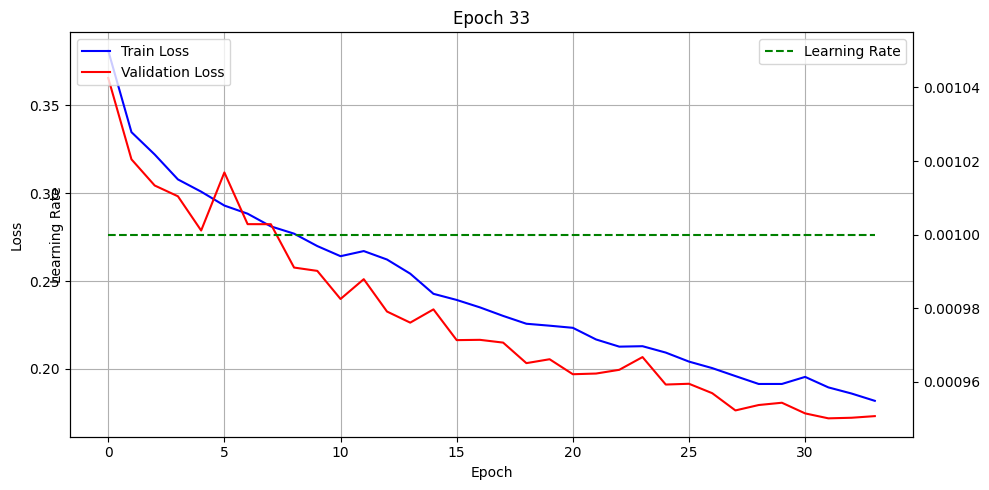

In [ ]:
from pathlib import Path
from simple_model.dataloader import ImagesLoader
from simple_model.nn import SegmentationConvolutionalNetwork
from simple_model.dataparse import download_all
import torch

minx, miny, maxx, maxy = 120000.0, 487500.0, 125000.0, 481250.0
bbox = (minx, miny, maxx, maxy)
data_folder = Path("data/region1")

if not data_folder.exists():
    data_folder.mkdir(parents=True, exist_ok=True)
    download_all(bbox, data_folder)

image_shape = (512, 512)
nodata = 0
images_path = data_folder / "dsm" / "tiles"
masks_path = data_folder / "mask" / "tiles"

images_loader = ImagesLoader(image_shape=image_shape, nodata=nodata)
images_loader.load_data(images_path, masks_path)
dataloaders = images_loader.get_dataloaders(batch_size=8, train_proportion=0.8)

model = SegmentationConvolutionalNetwork(image_size=image_shape)

# Better speed for CPU
torch.compile(model)

model.run(dataloaders=dataloaders, epochs=200, stop_early_after=15)

prediction_folder = data_folder / "prediction"
error_folder = data_folder / "error"
probabilities_folder = data_folder / "probabilities"
model.save_predictions(
    images_loader=images_loader,
    dataloaders=dataloaders,
    prediction_folder=prediction_folder,
    error_folder=error_folder,
    probabilities_folder=probabilities_folder,
)